### IMPORTS

In [1]:
from Inference import BBVI 

In [2]:
from Inference.Variational import MeanFieldVariationalDistribution

In [3]:
import torch
from torch import nn
from torch import functional as F
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLosses

In [4]:
def gaussian_entropy(sigma):
    return 0.5 * q.sigma.shape[0] * (1.0 + torch.log(2*torch.tensor(np.pi))) + torch.sum(torch.log(sigma))

In [5]:
def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [6]:
# Find what device to work with
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [8]:
# load data and make it in proper shape
data_val = torch.load('data/foong_data_validation.pt')
x_data_val = data_val[0].to(device)
y_data_val = data_val[1].to(device)
y_data_val = y_data_val.unsqueeze(-1)

In [1]:
import GPUtil

In [3]:
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 | 12% | 71% |


In [4]:
torch.cuda.memory_allocated(device=device)

NameError: name 'torch' is not defined

In [13]:
def logprior(x):
    return prior.log_prob(x)

In [14]:
def loglikelihood(x):
    Net.set_parameters(x)
    y_pred = Net(x_data)
    L = _log_norm(y_pred, y_data, torch.tensor([0.1],device=device))
    return torch.sum(L, dim=[1,2]).unsqueeze(-1)

In [15]:
def logposterior(x):
    return logprior(x) + loglikelihood(x)

In [29]:
def train():
    def logprior(x):
        return prior.log_prob(x)
    
    def loglikelihood(x):
        Net.set_parameters(x)
        y_pred = Net(x_data)
        L = _log_norm(y_pred, y_data, torch.tensor([0.1],device=device))
        return torch.sum(L, dim=[1,2]).unsqueeze(-1)
    
    def predictive_loglikelihood(x):
        Net.set_parameters(x)
        y_pred_val = Net(x_data_val)
        L = _log_norm(y_pred_val, y_data_val, torch.tensor([0.1],device=device))
        return torch.sum(L, dim=[1,2]).unsqueeze(-1)
    
    def logposterior(x):
        return logprior(x) + loglikelihood(x)
    
    Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=50, nb_layers=4, device=device)
    
    param_count = int(Net.count_parameters()/2)
    
    prior = MeanFieldVariationalDistribution(param_count, sigma=0.5, device=device)
    prior.mu.requires_grad = False
    prior.rho.requires_grad = False
    
    q = MeanFieldVariationalDistribution(param_count, sigma=0.0001, device=device)
    q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 
    
    q.rho.requires_grad = True
    q.mu.requires_grad = True
    
    n_samples_ELBO = 100
    
    optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)
    
    
    liveloss = PlotLosses()
    for t in range(10000):
        logs = {}
        optimizer.zero_grad()

        z = q.sample(n_samples_ELBO)
        LQ = q.log_prob(z)
        LP = logposterior(z)
        L = (LQ - 1000*LP).mean()
        
        with torch.no_grad():
            LL = predictive_loglikelihood(z).mean().detach().clone()

        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        logs['memory'] = torch.cuda.memory_allocated(device=device)
        logs['predictive likelihood'] = LL.detach().clone().cpu().numpy()
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.00001:
            break
    return q

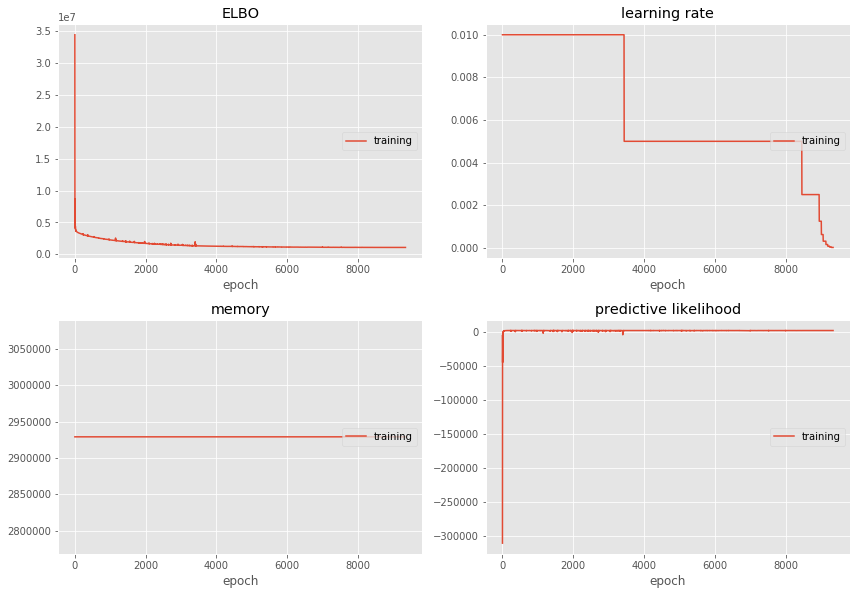

ELBO:
training   (min: 1078382.500, max: 140621920.000, cur: 1078579.750)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)

memory:
training   (min: 2843136.000, max: 2929152.000, cur: 2929152.000)

predictive likelihood:
training   (min: -1330061.250, max: 1773.000, cur: 1750.191)


In [30]:
%matplotlib inline
q = train()

In [ ]:
q.mu.detach_()
q.rho.detach_()

In [ ]:
q.rho.requires_grad = True
q.mu.requires_grad = False

In [ ]:
q.rho.requires_grad = False
q.mu.requires_grad = True

In [ ]:
dir()

In [ ]:
def marginal_loglikelihood(nb_samples, q, x, y):
    z = q.sample(nb_samples)
    Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=50, nb_layers=4, device=device)
    param_count = int(Net.count_parameters()/2)
    
    prior = MeanFieldVariationalDistribution(param_count, sigma=0.5, device=device)
    prior.mu.requires_grad = False
    prior.rho.requires_grad = False
    
    Net.set_parameters(z)
    y_pred = Net(x)
    L = _log_norm(y_pred, y, torch.tensor([0.1],device=device))
    loglikelihood = torch.sum(L, dim=[1,2]).unsqueeze(-1)

    logprior = prior.log_prob(z)
    return (logprior + loglikelihood).mean()

In [ ]:
marginal_loglikelihood(1000, q, x_data_val, y_data_val)

In [ ]:
Net = None

In [31]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)

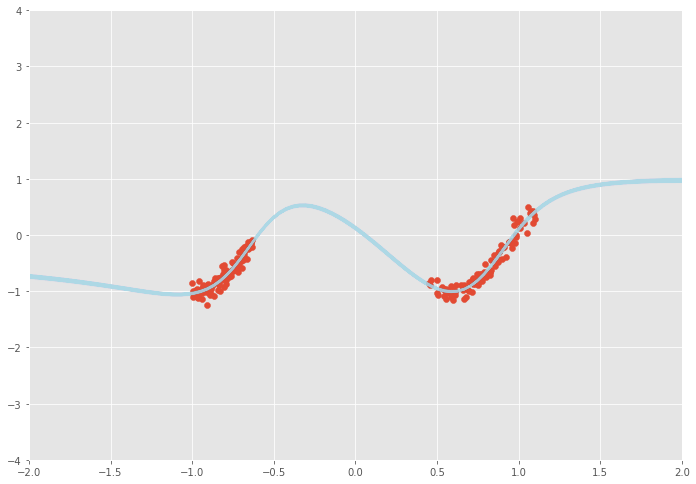

In [32]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = q.sample()
    Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=50, nb_layers=4, device=device)
    Net.set_parameters(z)

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [ ]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = prior.sample()
    Net.set_parameters(z)

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')